# Summary

Derive all the equations of GME theory (where possible), using SymPy, for a given erosion model type ($\sin\beta$ or $\tan\beta$), slope exponent $\eta \in \left\{\tfrac{1}{4}, \tfrac{1}{3}, \tfrac{1}{2}, \tfrac{3}{2}\right\}$, and ratio of area/slope exponent $\mu/\eta$ (usually set to 1/2).

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
#     pr_filenames = ['Derivation_sinbeta_eta1p5_ratio0p5']
    pr_filenames = ['Derivation_sinbeta_eta0p5_ratio0p5']
#     pr_filenames = ['Derivation_sinbeta_eta0p33_ratio1p0']
#     pr_filenames = ['Derivation_sinbeta_eta0p25_ratio1p0']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Preliminaries

In [2]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
from sympy import simplify, factor, powsimp, expand_power_base, collect, trigsimp, \
                    Rational, Matrix, Eq, poly, nroots, \
                    solve, sin, cos, tan, atan, asin, Abs, sqrt, re, im, N, \
                    numer, denom, expand, Piecewise, lambdify, deg, rad, pi, \
                    diff, sign, init_printing, plot, exp, integrate
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units \
    import Quantity, Dimension, \
            length, speed, velocity, time, \
            km, cm, mm, meter, meters, \
            year, second, seconds, \
            convert_to, percent, degrees, radians, mega
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, omitdict, round as gmround, convert
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import *
from gme.core.equations import Equations
from gme.plot.base import Graphing
from gme.plot.slicing import SlicingPlots

# Matplotlib
from matplotlib import pyplot as plt

# Quadrature method from SciPy
from scipy.integrate import cumtrapz

# # Import units & dimensions
# from sympy.physics.units \
#     import Quantity, Dimension, \
#             length, speed, velocity, time, \
#             km, cm, mm, meter, meters, \
#             year, second, seconds, \
#             convert_to, percent, degrees, radians, mega
# from sympy.physics.units.systems import SI

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['Derivation_sinbeta_eta0p5_ratio0p5'])

In [3]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'derivation',
    'subtitle': '',
    'title': 'Derivation of GME equations for sin(beta) erosion model, '
             'eta=1/2, mu=1/4',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}
{  

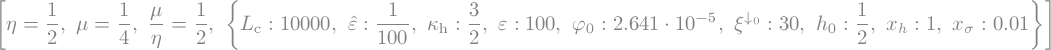

In [4]:
sub = {
        Lc: pr.model.Lc, 
        varepsilonhat: pr.model.varepsilonhat, 
        varepsilon: pr.model.varepsilonhat*pr.model.Lc, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
([Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), 
        sub])

# Basics

In [5]:
gmeq = Equations( eta=pr.model.eta, mu=pr.model.mu,
                  beta_type=pr.model.beta_type, varphi_type=pr.model.varphi_type, 
                  do_raw=True, do_nothing=True )

In [6]:
def eqns(eqn_list):
    return [getattr(gmeq, eqn) for eqn in eqn_list]

# Vector $\mathbf{{r}}$

In [7]:
gmeq.define_r_eqns()

In [8]:
eqns(['rx_r_alpha_eqn', 'rz_r_alpha_eqn'])

# Covector $\mathbf{\widetilde{p}}$

In [9]:
gmeq.define_p_eqns()

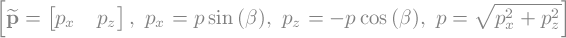

In [10]:
eqns(['p_covec_eqn', 'px_p_beta_eqn', 'pz_p_beta_eqn', 'p_norm_pxpz_eqn'])

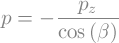

In [11]:
gmeq.p_pz_cosbeta_eqn

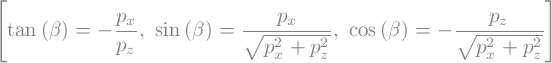

In [12]:
eqns(['tanbeta_pxpz_eqn', 'sinbeta_pxpz_eqn', 'cosbeta_pxpz_eqn'])

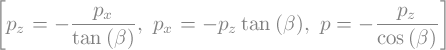

In [13]:
eqns(['pz_px_tanbeta_eqn', 'px_pz_tanbeta_eqn', 'p_pz_cosbeta_eqn'])

# Erosion model

### $\xi$ model

In [14]:
gmeq.define_xi_eqns()

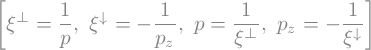

In [15]:
eqns(['xi_p_eqn', 'xiv_pz_eqn', 'p_xi_eqn', 'pz_xiv_eqn'])

In [16]:
gmeq.define_xi_model_eqn()

In [17]:
gmeq.xi_varphi_beta_eqn

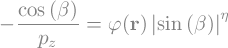

In [18]:
gmeq.xi_varphi_beta_eqn.subs(e2d(gmeq.xi_p_eqn)).subs(e2d(gmeq.p_pz_cosbeta_eqn))

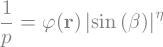

In [19]:
gmeq.xi_varphi_beta_eqn.subs(e2d(gmeq.xi_p_eqn))

### $\xi$ related eqns

In [20]:
gmeq.define_xi_related_eqns()

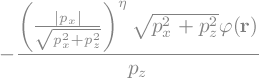

In [21]:
( (gmeq.xi_varphi_beta_eqn.rhs/cos(beta))
    .subs(e2d(gmeq.tanbeta_pxpz_eqn))
    .subs(e2d(gmeq.cosbeta_pxpz_eqn))
    .subs(e2d(gmeq.sinbeta_pxpz_eqn))
    .subs({(-Abs(px)/pz)**eta:px**eta/(-pz)**eta})
)

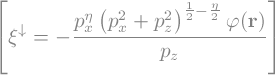

In [22]:
eqns(['xiv_varphi_pxpz_eqn'])

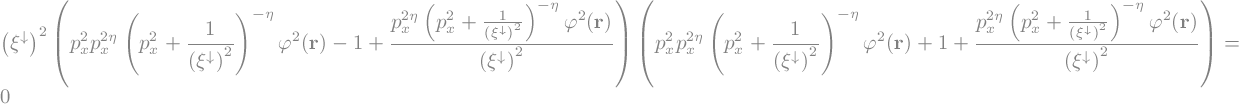

In [23]:
gmeq.px_xiv_varphi_eqn

### $\varphi$ model

In [24]:
gmeq.define_varphi_model_eqn()
gmeq.varphi_type

'ramp'

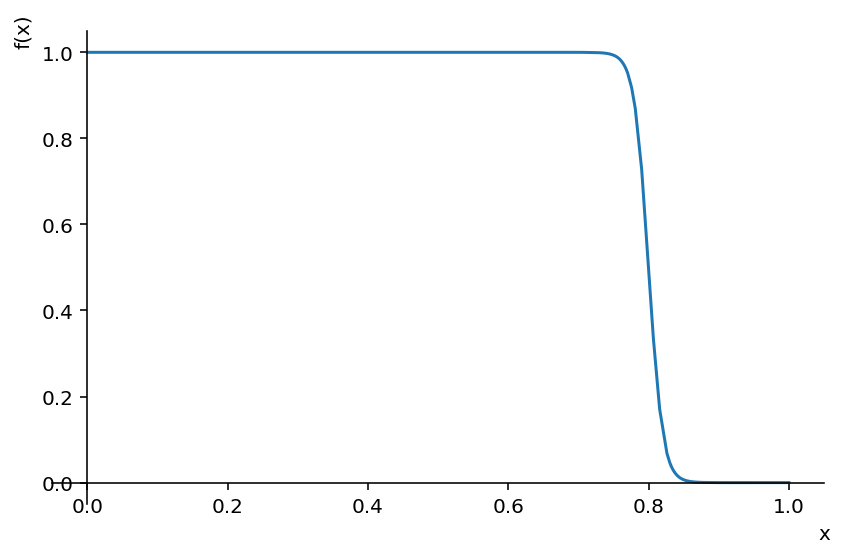

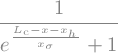

In [25]:
smooth_step_fn = 1/(1+exp(((x_1-x_h)-x)/x_sigma))
plot(smooth_step_fn.subs({x:x_1-x}).subs({x_sigma:0.01, x_h:0.8, x_1:1}), (x,0,1));
simplify(smooth_step_fn)

In [26]:
tmpsub = {x_sigma:0.01, chi:30, x_h:0.8, x_1:1, varphi_0:1, mu:2}

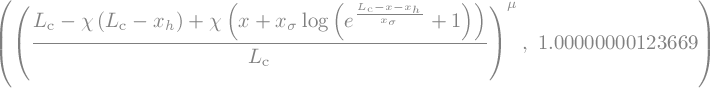

In [27]:
smooth_break_fn = simplify( ((chi/(x_1))*(
    integrate(smooth_step_fn,x))-chi*(1-x_h/x_1)+1)**mu )
smooth_break_fn, smooth_break_fn.subs({x:x_1-rx}).subs({rx:x_1}).subs(tmpsub)

In [28]:
# p=sy.plot(smooth_break_fn.subs({x:x_1-rx}).subs(tmpsub),
#           gmeq.varphi_model_rampflatmu_eqn.rhs.subs(tmpsub), 
#           (rx,0,1), show=False);
# p[0].line_color = ['red','white']
# p.show()

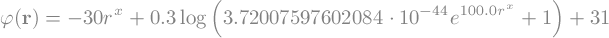

In [29]:
gmeq.varphi_model_rampflat_eqn.subs(tmpsub)

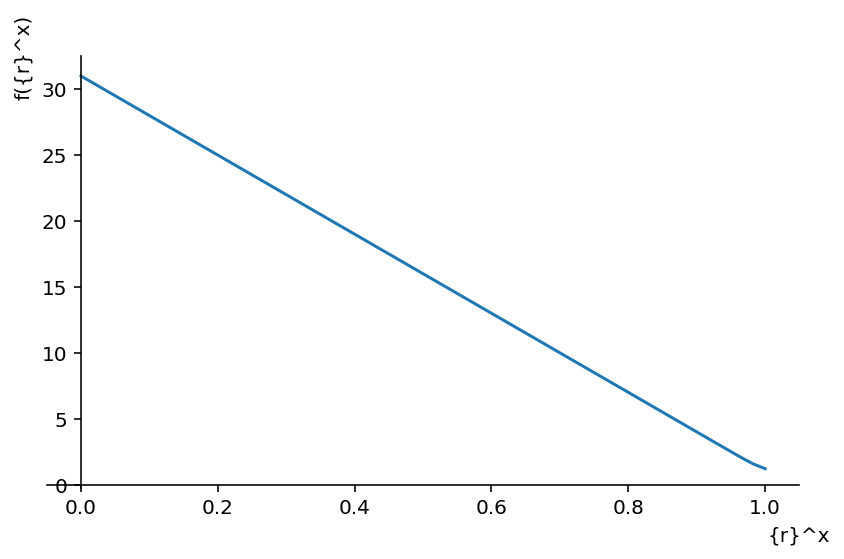

In [30]:
plot(gmeq.varphi_model_rampflat_eqn.rhs.subs(tmpsub), (rx,0,1));

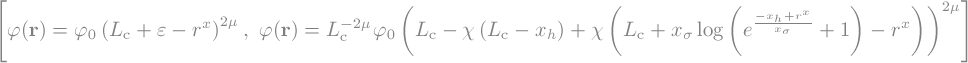

In [31]:
eqns(['varphi_model_ramp_eqn','varphi_model_rampflatmu_eqn'])

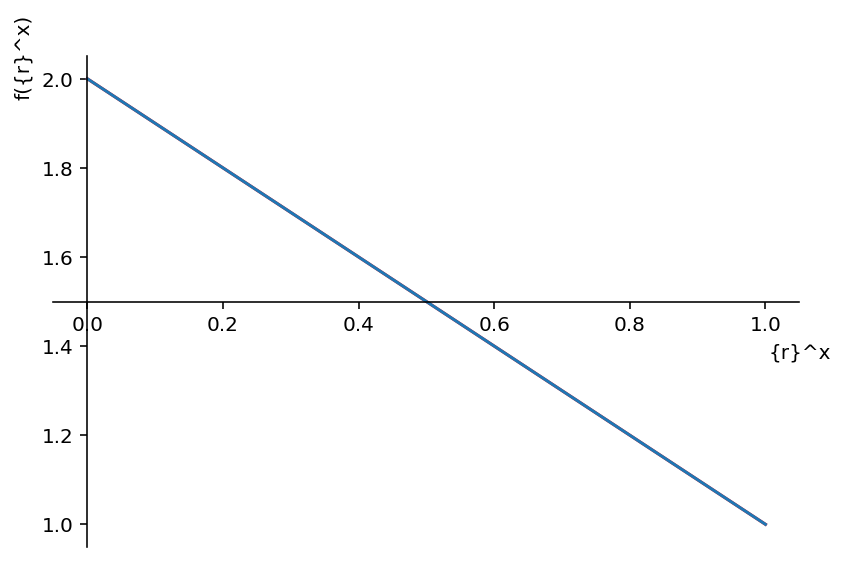

In [32]:
p = plot(gmeq.varphi_model_ramp_eqn.rhs
            .subs({varphi_0:1, varepsilon:1, x_1:1, mu:Rational(1,2)}),
 gmeq.varphi_model_ramp_eqn.rhs.subs({varphi_0:1, varepsilon:1, x_1:1, mu:Rational(1,2)}), 
        (rx,0,1), show=False);
p[0].line_color = 'red'
p.show()

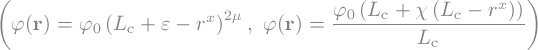

In [33]:
gmeq.varphi_model_ramp_eqn.subs({x_sigma:0}), \
    simplify(gmeq.varphi_model_rampflat_eqn.subs({x_sigma:0}))

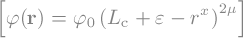

In [34]:
eqns(['varphi_rx_eqn'])

### $\varphi$ related eqns

In [35]:
gmeq.define_varphi_related_eqns()

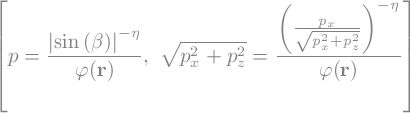

In [36]:
eqns(['p_varphi_beta_eqn', 'p_varphi_pxpz_eqn'])

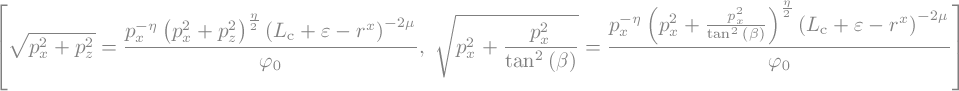

In [37]:
eqns(['p_rx_pxpz_eqn', 'p_rx_tanbeta_eqn'])

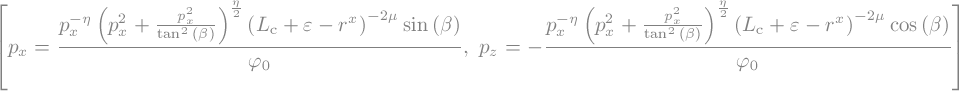

In [38]:
eqns(['px_beta_eqn', 'pz_beta_eqn'])

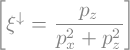

In [39]:
eqns(['xiv_pxpz_eqn'])

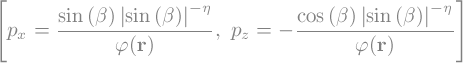

In [40]:
eqns(['px_varphi_beta_eqn', 'pz_varphi_beta_eqn'])

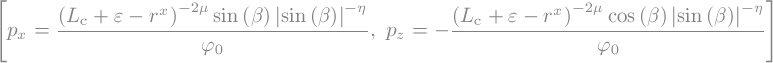

In [41]:
eqns(['px_varphi_rx_beta_eqn','pz_varphi_rx_beta_eqn'])

### $p_x$ polynomial

This polynomial in $p_x$, or in $\tan\beta=-p_x/p_z=-p_x\xi^{\downarrow 0}$, is a polynomial in gradient $dz/dx$, which means (if it can be solved for) it can be integrated to give $z(x)$.

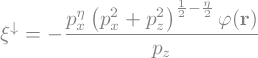

In [42]:
gmeq.xiv_varphi_pxpz_eqn

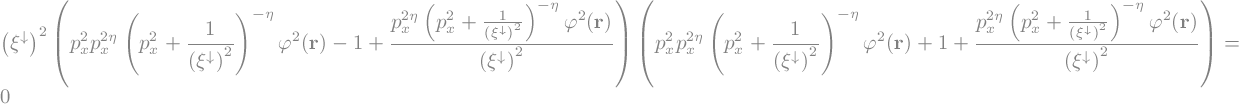

In [43]:
gmeq.px_xiv_varphi_eqn

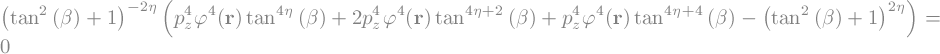

In [44]:
p0 = Eq( (simplify(expand(gmeq.px_xiv_varphi_eqn.lhs/xiv**2).subs({px:-pz*tan(beta), xiv:-1/pz})) 
    .subs({cos(beta):1/sqrt(1+tan(beta)**2)})), 0)
p0

In [45]:
p_eta1p5 = Eq( numer(factor(p0.lhs.subs({eta:gmeq.eta}))), 0)
p_eta1p5

In [46]:
gmeq.define_px_poly_eqn(eta_choice=gmeq.eta)

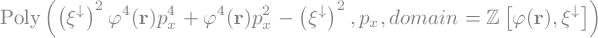

In [47]:
gmeq.poly_px_xiv_varphi_eqn

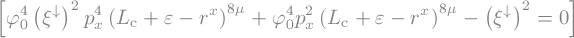

In [48]:
eqns(['poly_px_xiv_eqn'])

In [49]:
# gmeq.define_px_poly_eqn(eta_choice=Rational(3,2))

In [50]:
# gmeq.poly_px_xiv_varphi_eqn

In [51]:
# eqns(['poly_px_xiv0_eqn'])

# Fundamental function & Hamiltonian

In [52]:
gmeq.define_Fstar_eqns()

In [53]:
gmeq.define_H_eqns()

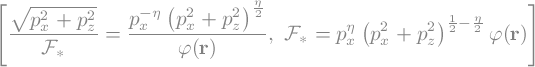

In [54]:
eqns(['Okubo_Fstar_eqn', 'Fstar_eqn'])

$
    \mathcal{H} := \dfrac{\varphi^2 p_x^{2\eta}}{2\left(p_x^2+p_z^2\right)^{\eta-1}}
$

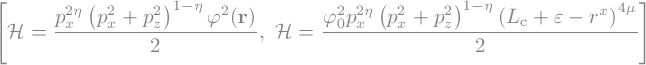

In [55]:
eqns(['H_eqn', 'H_varphi_rx_eqn'])

# Hamilton's equations

ODE $\dot{\mathbf{r}}$ components

In [56]:
gmeq.define_rdot_eqns()

In [57]:
eqns(['rdotx_rdot_alpha_eqn', 'rdotz_rdot_alpha_eqn'])

Derivation of $v^z$ gives zero if the Hamiltonian has no dependence on $p_z$, which happens if the angle function is $\sin\beta$ and if its exponent is $\eta=1$. From this point on, such a model fails.

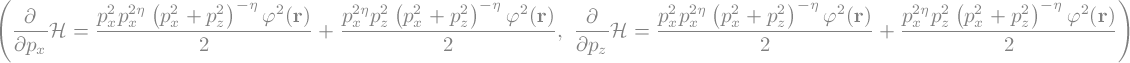

In [58]:
factor( diff(gmeq.H_eqn,px) ), factor( diff(gmeq.H_eqn,pz) )

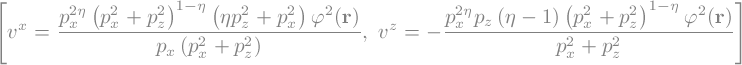

In [59]:
eqns(['rdotx_pxpz_eqn', 'rdotz_pxpz_eqn'])

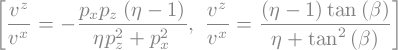

In [60]:
eqns(['rdotz_on_rdotx_eqn', 'rdotz_on_rdotx_tanbeta_eqn'])

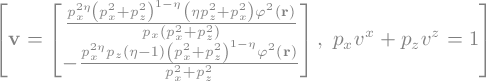

In [61]:
eqns(['rdot_vec_eqn', 'rdot_p_unity_eqn'])

ODE $\dot{\mathbf{\widetilde{p}}}$ components

In [62]:
gmeq.define_pdot_eqns()

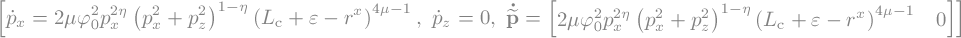

In [63]:
eqns(['pdotx_pxpz_eqn', 'pdotz_pxpz_eqn', 'pdot_covec_eqn'])

Combined ODE components

In [64]:
gmeq.define_Hamiltons_eqns()

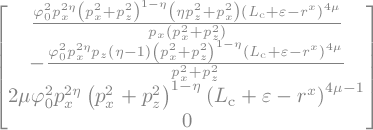

In [65]:
gmeq.hamiltons_eqns #, gmeq.hamiltons_eqns.subs({zeta:gmeq.zeta})

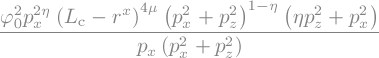

In [66]:
gmeq.hamiltons_eqns[0].subs({varepsilon:0})

# Non-dimensionalization

In [67]:
gmeq.nondimensionalize()

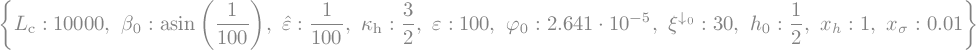

In [68]:
sub.update({
#     xiv_0: pr.model.xiv_0,
#     varepsilon: pr.model.varepsilon,
    beta_0: asin(Rational(1,100))
})
sub

In [69]:
gmeq.rx_rxhat_eqn, gmeq.rz_rzhat_eqn

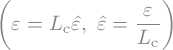

In [70]:
gmeq.varepsilon_varepsilonhat_eqn, gmeq.varepsilonhat_varepsilon_eqn

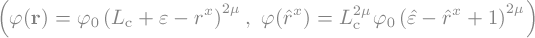

In [71]:
gmeq.varphi_rx_eqn, gmeq.varphi_rxhat_eqn

In [72]:
gmeq.xi_rxhat_eqn

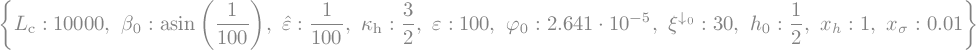

In [73]:
sub

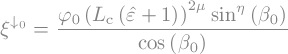

In [74]:
gmeq.xiv0_beta0_eqn

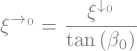

In [75]:
gmeq.xih0_xiv0_beta0_eqn

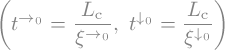

In [76]:
gmeq.th0_xih0_eqn, gmeq.tv0_xiv0_eqn

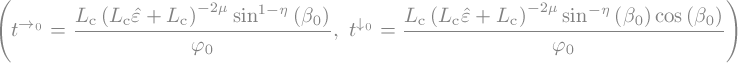

In [77]:
gmeq.th0_beta0_eqn, gmeq.tv0_beta0_eqn

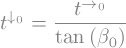

In [78]:
Eq(tv_0, th_0*simplify((tv_0/th_0)
                         .subs(e2d(gmeq.tv0_beta0_eqn))
                         .subs(e2d(gmeq.th0_beta0_eqn))) )

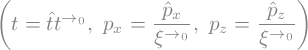

In [79]:
gmeq.t_that_eqn, gmeq.px_pxhat_eqn, gmeq.pz_pzhat_eqn

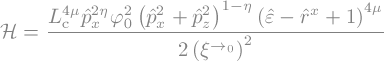

In [80]:
gmeq.H_varphi_rxhat_eqn

<!-- The geomorphic Hamiltonian parameterized using dimensionless variables is

$
    \mathcal{H} = \dfrac{\mathsf{Ci}^2 \left( 1-\hat{r}^x \right)^{4\mu} \hat{p}_x^{2\eta}}
              {2  \left( \hat{p}_x^2+\hat{p}_z^2 \right)^{\eta-1}}
$

where $\mathsf{Ci}$ is the channel incision number defined as

$
    \mathsf{Ci} := \dfrac{L_{\mathrm{c}}^{2\mu} \varphi_0}{\xi^{\rightarrow_0}}
                 = \left( \sin\beta_0 \right)^{1-\eta}
$ -->

The geomorphic Hamiltonian parameterized using dimensionless variables is

<!-- $
    \mathcal{H} 
%         = \dfrac{\mathsf{Ci}^{2(1-\eta)} \left( 1-\hat{r}^x \right)^{4\mu} \hat{p}_x^{2\eta}}
%                 {2  \left( \hat{p}_x^2+\hat{p}_z^2 \right)^{\eta-1}}
        = \dfrac{ \left( 1-\hat{r}^x \right)^{4\mu} \hat{p}_x^{2\eta}}
                {2 \left( \mathsf{Ci}^2 \! \left( \hat{p}_x^2+\hat{p}_z^2 \right) \right)^{\eta-1}}
$

where $\mathsf{Ci}$ is the channel incision number defined as

$
    \mathsf{Ci} := \left(
                    \dfrac{L_{\mathrm{c}}^{2\mu} \varphi_0}{\xi^{\rightarrow_0}}
                    \right)^{\tfrac{1}{1-\eta}}
                 = \sin\beta_0 
$

or more simply
 -->
$
    \mathcal{H} 
%         = \dfrac{\mathsf{Ci}^{2(1-\eta)} \left( 1-\hat{r}^x \right)^{4\mu} \hat{p}_x^{2\eta}}
%                 {2  \left( \hat{p}_x^2+\hat{p}_z^2 \right)^{\eta-1}}
        = \dfrac{ \hat{p}_x^{2\eta} \left( 1-\hat{r}^x \right)^{4\mu} }
                {2 \left(  \! \left( \hat{p}_x^2+\hat{p}_z^2 \right) \sin^2\!\mathsf{Ci} \right)^{\eta-1}}
$

where the channel incision number (angle) $\mathsf{Ci}$ is defined as

$
    \mathsf{Ci} := \arcsin\,\left(\left(
                    \dfrac{L_{\mathrm{c}}^{2\mu} \varphi_0}{\xi^{\rightarrow_0}}
                    \right)^{\tfrac{1}{1-\eta}}\right)
    \qquad\text{where}\quad
    \mathsf{Ci} \approx \beta_0 \quad\text{if}\quad \hat{\varepsilon} \ll 1
$

In [81]:
gmeq.H_split

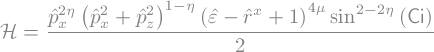

In [82]:
gmeq.H_Ci_eqn

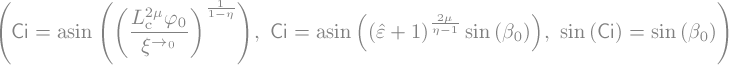

In [83]:
(gmeq.Ci_xih0_eqn, (gmeq.Ci_beta0_eqn)
    , trigsimp( gmeq.sinCi_beta0_eqn.subs({varepsilonhat:0}) ))

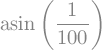

In [84]:
beta_0.subs(sub)

In [85]:
( 
    gmround(( gmeq.xiv0_beta0_eqn
                 .subs({varepsilonhat:0})
                 .subs(omitdict(sub,[xiv_0]))
                 .subs({eta:pr.model.eta, mu:pr.model.mu}) ), 4),
    gmround(( gmeq.xih0_beta0_eqn
                 .subs({varepsilonhat:0})
                 .subs(omitdict(sub,[xiv_0]))
                 .subs({eta:pr.model.eta, mu:pr.model.mu}) ), 4),
    gmround(( gmeq.Ci_beta0_eqn
                 .subs({varepsilonhat:0})
                 .subs(omitdict(sub,[xiv_0]))
                 .subs({eta:pr.model.eta, mu:pr.model.mu}) ), 4) 
)

In [86]:
( 
    gmround(( gmeq.xiv0_beta0_eqn
                 .subs(e2d(gmeq.varepsilonhat_varepsilon_eqn))
                 .subs(omitdict(sub,[xiv_0]))
                 .subs({eta:pr.model.eta, mu:pr.model.mu}) ), 4),
    gmround(( gmeq.xih0_beta0_eqn
                 .subs(e2d(gmeq.varepsilonhat_varepsilon_eqn))
                 .subs(omitdict(sub,[xiv_0]))
                 .subs({eta:pr.model.eta, mu:pr.model.mu}) ), 4),
    gmround(( gmeq.Ci_beta0_eqn
                 .subs(e2d(gmeq.varepsilonhat_varepsilon_eqn))
                 .subs(omitdict(sub,[xiv_0]))
                 .subs({eta:pr.model.eta, mu:pr.model.mu}) ), 4) 
)

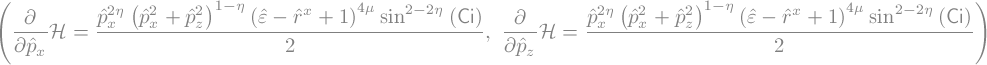

In [87]:
simplify( diff(gmeq.H_Ci_eqn,pxhat) ), simplify( diff(gmeq.H_Ci_eqn,pzhat) )

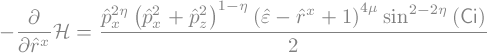

In [88]:
simplify( -diff(gmeq.H_Ci_eqn,rxhat) )#, -simplify( sy.diff(gmeq.H_Ci_eqn,rzhat) )

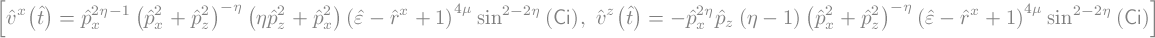

In [89]:
([gmeq.rdotxhat_eqn, gmeq.rdotzhat_eqn])

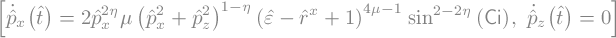

In [90]:
([gmeq.pdotxhat_eqn, gmeq.pdotzhat_eqn])

# Non-dimensionalized Hamilton's equations

In [91]:
gmeq.define_nodimensionalized_Hamiltons_eqns()

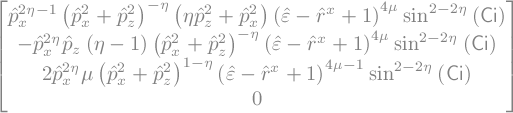

In [92]:
gmeq.hamiltons_ndim_eqns

# Profile

In [93]:
gr = Graphing()

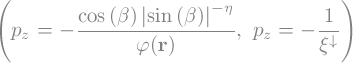

In [94]:
gmeq.pz_varphi_beta_eqn, gmeq.pz_xiv_eqn

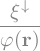

In [95]:
xiv/varphi_r(rvec)

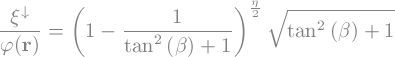

In [96]:
tmp_eqn = Eq((xiv/varphi_r(rvec)), 
        solve(simplify( gmeq.pz_varphi_beta_eqn
                           .subs(e2d(gmeq.pz_xiv_eqn))
                           .subs({Abs(sin(beta)):sin(beta)})
                      ), xiv)[0]/varphi_r(rvec)
            )
xiv_eqn = ( tmp_eqn
               .subs({sin(beta):sqrt(1-cos(beta)**2)})
               .subs({cos(beta):sqrt(1/(1+tan(beta)**2))}) )
xiv_eqn

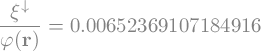

In [97]:
xiv_eqn.subs({eta:Rational(3,2), beta:rad(2)}).n()

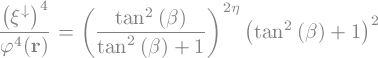

In [98]:
xvi_abs_eqn = factor(Eq(xiv_eqn.lhs**4, (xiv_eqn.rhs)**4))
xvi_abs_eqn

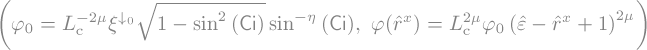

In [99]:
gmeq.varphi0_Lc_xiv0_Ci_eqn.subs({varepsilonhat:0}), gmeq.varphi_rxhat_eqn

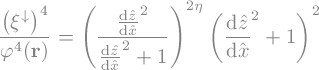

In [100]:
dzdx_polylike_eqn = ( 
    xvi_abs_eqn.subs({tan(beta):dzdx})
)
dzdx_polylike_eqn

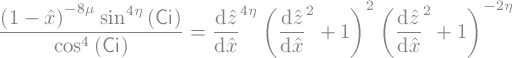

In [101]:
dzdx_Ci_polylike_prelim_eqn = (expand_power_base( 
    dzdx_polylike_eqn
        .subs(e2d(gmeq.varphi_rx_eqn))
        .subs(e2d(gmeq.varphi0_Lc_xiv0_Ci_eqn))
        .subs({xiv:xiv_0})
        .subs({varepsilon:varepsilonhat*Lc})
        .subs({rx:xhat*Lc})
        .subs({Lc*varepsilonhat-Lc*xhat+Lc:Lc*(varepsilonhat-xhat+1)})
)).subs({Abs(dzdx):dzdx})
trigsimp(dzdx_Ci_polylike_prelim_eqn.subs({varepsilonhat:0}))

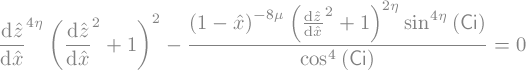

In [102]:
dzdx_Ci_polylike_eqn = Eq(
    dzdx_Ci_polylike_prelim_eqn.rhs*((dzdx**2+1)**(2*eta))
    - (dzdx_Ci_polylike_prelim_eqn.lhs*((dzdx**2+1)**(2*eta))),
    0
).subs({pzhat_0:1/xivhat_0})
(trigsimp(dzdx_Ci_polylike_eqn.subs({varepsilonhat:0})))

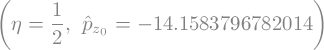

In [103]:
eta_ = Rational(1,2)
(
    Eq(eta,eta_), 
    Eq(pzhat_0, solve( (trigsimp(dzdx_Ci_polylike_eqn
          .subs({mu:eta/2})
          .subs({varepsilonhat:0.01, Ci:rad(4), eta:eta_})
          .subs({xhat:0}).n()
         )), 1/dzdx )[0])
)

In [104]:
def find_dzdx_poly_root(dzdx_poly_, xhat_, xivhat0_):
    dzdx_poly_roots = nroots(dzdx_poly_.subs({xhat:xhat_, xivhat_0:xivhat0_}))
    dzdx_poly_root = [root_ for root_ in dzdx_poly_roots 
                       if Abs(im(root_))<1e-10 and re(root_)>0][0]
    return dzdx_poly_root

def make_dzdx_poly(dzdx_Ci_polylike_eqn_, eta_,mu_,Ci_,varepsilonhat_,xivhat0_, sub):
    dzdx_eqn_ = N(
        dzdx_Ci_polylike_eqn_
            .subs({eta:eta_, mu:mu_, Ci:Ci_, varepsilonhat:varepsilonhat_, xivhat_0:xivhat0_})
            .subs(sub)
    )
    return poly(dzdx_eqn_.lhs,dzdx)

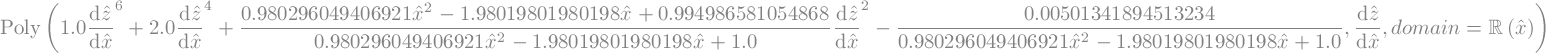

In [105]:
Ci_ = rad(4)
xivhat0_ = 1
varepsilonhat_ = Rational(1,100)
n_pts = 200

eta_, mu_ = Rational(1,2), Rational(1,4)
dzdx_poly_eta0p5_ = make_dzdx_poly(dzdx_Ci_polylike_eqn, 
                                   eta_,mu_,Ci_,varepsilonhat_,xivhat0_, sub)
eta_, mu_ = Rational(3,2), Rational(3,4)
dzdx_poly_eta1p5_ = make_dzdx_poly(dzdx_Ci_polylike_eqn, 
                                   eta_,mu_,Ci_,varepsilonhat_,xivhat0_, sub)
dzdx_poly_eta0p5_

In [106]:
xhat_array = np.linspace(0,0.95, n_pts, endpoint=True)
dzdxhat_eta0p5_array = [find_dzdx_poly_root(dzdx_poly_eta0p5_, xhat_,xivhat0_) 
                        for xhat_ in xhat_array]
dzdxhat_eta1p5_array = [find_dzdx_poly_root(dzdx_poly_eta1p5_, xhat_,xivhat0_) 
                        for xhat_ in xhat_array]
zhat_eta0p5_array = cumtrapz(dzdxhat_eta0p5_array, xhat_array, initial=0)
zhat_eta1p5_array = cumtrapz(dzdxhat_eta1p5_array, xhat_array, initial=0)

In [107]:
(
    dzdxhat_eta0p5_array[0], np.rad2deg(np.arctan(float(dzdxhat_eta0p5_array[0]))),
    dzdxhat_eta1p5_array[0], np.rad2deg(np.arctan(float(dzdxhat_eta1p5_array[0])))
)

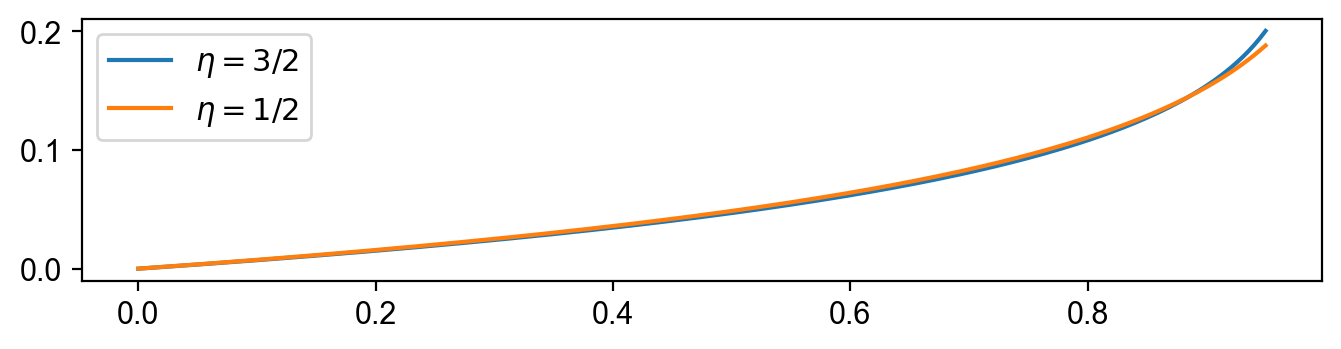

In [108]:
fig_name_ = 'profile_directly_integrated'
fig = gr.create_figure(fig_name_)

plt.plot(xhat_array, zhat_eta1p5_array, label=r'$\eta=3/2$')
plt.plot(xhat_array, zhat_eta0p5_array, label=r'$\eta=1/2$')
plt.legend()
axes = plt.gca()
axes.set_aspect(1)

# Real-world numbers

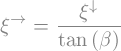

In [109]:
gmeq.xih_xiv_tanbeta_eqn

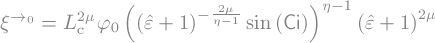

In [110]:
gmeq.xih0_Lc_varphi0_Ci_eqn

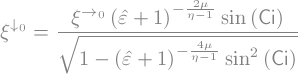

In [111]:
gmeq.xiv0_xih0_Ci_eqn

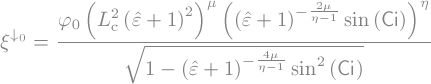

In [112]:
gmeq.xiv0_Lc_varphi0_Ci_eqn

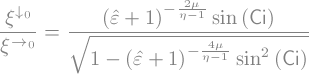

In [113]:
gmeq.ratio_xiv0_xih0_eqn

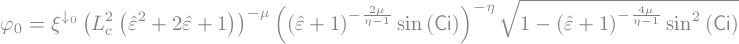

In [114]:
gmeq.varphi0_Lc_xiv0_Ci_eqn

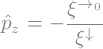

In [115]:
gmeq.pzhat_xiv_eqn

In [116]:
t_oneyear_eqn_ = Eq(t_oneyear, float((convert_to(year,second)).args[0]))
t_My_eqn_ = Eq(t_My, float((convert_to(mega*year,second)).args[0]))
(convert(t_oneyear_eqn_, n=0, units=year), convert(t_My_eqn_, n=0, units=year))

(t_{\mathrm{1y}} = 1.0⋅tropical_year, t_{\mathrm{My}} = 1000000.0⋅tropical_yea
r)

In [117]:
xiv0_ = (1e-3/t_oneyear).subs(e2d(t_oneyear_eqn_))
Ci_   = rad(Rational(1,10))
Lc_   = 1e4
eta_  = Rational(1,2)
mu_   = Rational(1,4)

These dimensionless timings and heights are pulled from runs of TimeInvariant.nb

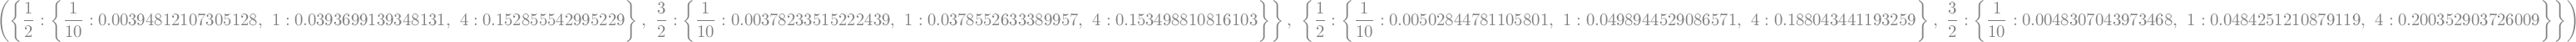

In [118]:
h0p9_Ci_results = {
    Rational(1,2): {
        Rational(1,10): 0.00394812107305128,
        1: 0.0393699139348131,
        4: 0.152855542995229
    },
    Rational(3,2): {
        Rational(1,10): 0.00378233515222439,
        1: 0.0378552633389957,
        4: 0.153498810816103
    }
}

h0p95_Ci_results = {
    Rational(1,2): {
        Rational(1,10): 0.00502844781105801,
        1: 0.0498944529086571,
        4: 0.188043441193259
    },
    Rational(3,2): {
        Rational(1,10): 0.0048307043973468,
        1: 0.0484251210879119,
        4: 0.200352903726009
    }
}
h0p9_Ci_results, h0p95_Ci_results

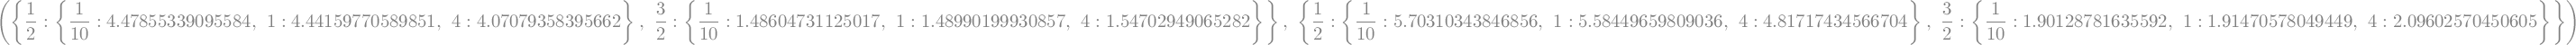

In [119]:
th0p9_Ci_results = {
    Rational(1,2): {
        Rational(1,10): 4.47855339095584,
        1: 4.44159770589851,
        4: 4.07079358395662
    },
    Rational(3,2): {
        Rational(1,10): 1.48604731125017,
        1: 1.48990199930857,
        4: 1.54702949065282
    }
}

th0p95_Ci_results = {
    Rational(1,2): {
        Rational(1,10): 5.70310343846856,
        1: 5.58449659809036,
        4: 4.81717434566704
    },
    Rational(3,2): {
        Rational(1,10): 1.90128781635592,
        1: 1.91470578049449,
        4: 2.09602570450605
    }
}
th0p9_Ci_results, th0p95_Ci_results

In [120]:
def build_results_table(xiv0_=1e-3, varepsilonhat_=0):
    xiv0_mps_ = (xiv0_/t_oneyear).subs(e2d(t_oneyear_eqn_))

    m_base = Matrix([
        [eta, Ci, Lc, tan(beta_0), xiv_0, xih_0, th_0, th_0p95, h_0p95],
        [1, degrees, km, percent, mm/year, mm/year, mega*year, mega*year, meters]
    ])
    m_all = m_base

    eta_Ci_Lc_list = [ 
        [Rational(1,2), rad(Rational(1,10)), 1e4], 
        [Rational(3,2), rad(Rational(1,10)), 1e4], 

        [Rational(1,2), rad(Rational(1,10)), 1e5], 
        [Rational(3,2), rad(Rational(1,10)), 1e5], 

        [Rational(1,2), rad(1), 1e4], 
        [Rational(3,2), rad(1), 1e4], 

        [Rational(1,2), rad(1), 1e5], 
        [Rational(3,2), rad(1), 1e5], 

        [Rational(1,2), rad(4), 1e4],
        [Rational(3,2), rad(4), 1e4],

        [Rational(1,2), rad(4), 5e3],
        [Rational(3,2), rad(4), 5e3],

    ]
    for eta_,Ci_,Lc_ in eta_Ci_Lc_list:
        Ci_eqn_ = (
            Eq(Ci,Ci_)
        )
        Lc_eqn_ = (
            Eq(Lc,Lc_)
        )
        varphi0_eqn_ = (
            gmeq.varphi0_Lc_xiv0_Ci_eqn.subs({Lc:Lc_, Ci:Ci_})
                        .subs({eta:eta_, mu:mu_})
                        .subs({xiv_0:xiv0_mps_})
                        .subs({varepsilonhat:varepsilonhat_})
        ).n()
        xiv0_eqn_ = (
            Eq(xiv_0,xiv0_mps_)
        )
        xih0_ = float(xiv0_/tan(Ci_))
        xih0_eqn_ = (
            gmeq.xih0_Lc_varphi0_Ci_eqn
                    .subs({Lc:Lc_, Ci:Ci_})
                    .subs({eta:eta_, mu:mu_})
                    .subs({xiv_0:xiv0_mps_})
                    .subs({varphi_0:varphi0_eqn_.rhs})
                    .subs({varepsilonhat:varepsilonhat_})
        ).n()
        beta0_Ci_eqn_ = (
            Eq(tan(beta_0), tan(beta_0)
                    .subs(e2d(gmeq.beta0_Ci_eqn))
                    .subs({Lc:Lc_, Ci:Ci_})
                    .subs({eta:eta_, mu:mu_})
                    .subs({varepsilonhat:varepsilonhat_}))
        ).n()
        th0_eqn_ = (
            Eq( th_0, (th_0*t_oneyear*1e-6).subs(e2d(t_oneyear_eqn_))
                                      .subs(e2d(gmeq.th0_xih0_eqn))
                                      .subs({Lc:Lc_, xih_0:xih0_}) )
        )
        th0p95_eqn_ = (
            Eq( th_0p95, th0p95_Ci_results[eta_][deg(Ci_)]*(th_0*t_oneyear*1e-6)
                                      .subs(e2d(t_oneyear_eqn_))
                                      .subs(e2d(gmeq.th0_xih0_eqn))
                                      .subs({Lc:Lc_, xih_0:xih0_}) )
        )
        h0p95_eqn_ = (
            Eq( h_0p95, h0p95_Ci_results[eta_][deg(Ci_)]*(Lc_) )
        )
        m_this = Matrix([
            [
                eta_,
                convert(Ci_eqn_,       n=2, units=degrees).rhs.args[0],
                convert(Lc_eqn_,       n=0, units=km).rhs.args[0],
                convert(beta0_Ci_eqn_, n=2, units=percent).rhs.args[0],
                convert(xiv0_eqn_,     n=3, units=mm/year).rhs.args[0],
                convert(xih0_eqn_,     n=1, units=mm/year).rhs.args[0],
                convert(th0_eqn_,      n=3, units=year).rhs.args[0],
                convert(th0p95_eqn_,   n=3, units=year).rhs.args[0],
                convert(h0p95_eqn_,    n=2, units=meters, do_raw=True).rhs.args[0]
            ]
        ])
        m_all = Matrix([m_all, m_this])
    return m_all

In [121]:
build_results_table(xiv0_=1e-3, varepsilonhat_=1e-2)

⎡\eta  \mathsf{Ci}  L_\mathrm{c}  tan(\beta₀)  \xi_{0}}__{\downarrow  \xi_{0}}
⎢                                                                             
⎢                                                    millimeter             mi
⎢ 1         °        kilometer      percent        ─────────────          ────
⎢                                                  tropical_year          trop
⎢                                                                             
⎢1/2       0.1          10.0         0.18               1.0                   
⎢                                                                             
⎢3/2       0.1          10.0         0.17               1.0                   
⎢                                                                             
⎢1/2       0.1         100.0         0.18               1.0                   
⎢                                                                             
⎢3/2       0.1         100.0         0.17           

In [122]:
build_results_table(xiv0_=1e-2, varepsilonhat_=1e-2)

⎡\eta  \mathsf{Ci}  L_\mathrm{c}  tan(\beta₀)  \xi_{0}}__{\downarrow  \xi_{0}}
⎢                                                                             
⎢                                                    millimeter             mi
⎢ 1         °        kilometer      percent        ─────────────          ────
⎢                                                  tropical_year          trop
⎢                                                                             
⎢1/2       0.1          10.0         0.18              10.0                   
⎢                                                                             
⎢3/2       0.1          10.0         0.17              10.0                   
⎢                                                                             
⎢1/2       0.1         100.0         0.18              10.0                   
⎢                                                                             
⎢3/2       0.1         100.0         0.17           

# Angles

### $\tan\alpha$

In [123]:
gmeq.define_tanalpha_eqns()

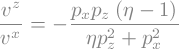

In [124]:
gmeq.rdotz_on_rdotx_eqn

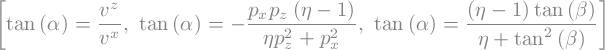

In [125]:
eqns(['tanalpha_rdot_eqn', 'tanalpha_pxpz_eqn', 'tanalpha_beta_eqn'])

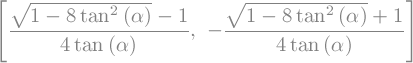

In [126]:
solve( simplify( gmeq.tanalpha_beta_eqn.subs({eta:gmeq.eta}) ), tan(beta) )

### $\tan\beta_c$, $\tan\alpha_c$

In [127]:
gmeq.define_tanbeta_eqns()

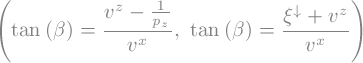

In [128]:
gmeq.tanbeta_rdotxz_pz_eqn, gmeq.tanbeta_rdotxz_xiv_eqn

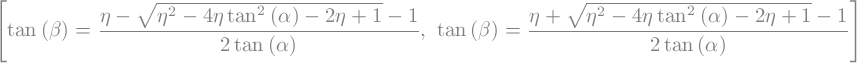

In [129]:
gmeq.tanbeta_alpha_eqns

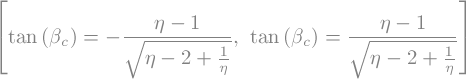

In [130]:
gmeq.tanbeta_crit_eqns

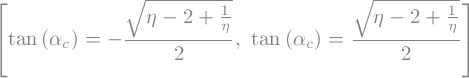

In [131]:
gmeq.tanalpha_crit_eqns

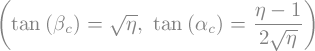

In [132]:
gmeq.tanbeta_crit_eqn, gmeq.tanalpha_crit_eqn

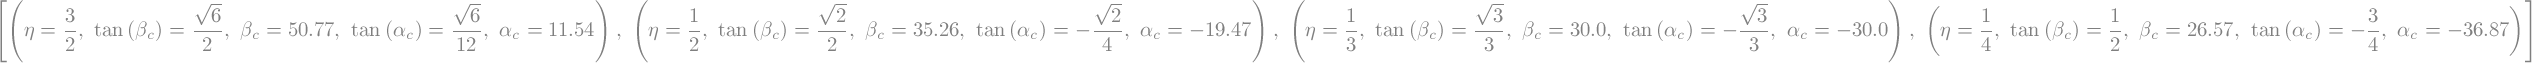

In [133]:
([(  Eq(eta,eta_), 
           gmeq.tanbeta_crit_eqn.subs({eta:eta_}),
           Eq(beta_crit, round(N(deg(atan(gmeq.tanbeta_crit_eqn.rhs.subs({eta:eta_})))),2)),
           gmeq.tanalpha_crit_eqn.subs({eta:eta_}),
           Eq(alpha_crit, round(N(deg(atan(gmeq.tanalpha_crit_eqn.rhs.subs({eta:eta_})))),2)) )
 for eta_ in [Rational(3,2),Rational(1,2),Rational(1,3),Rational(1,4)]])

In [134]:
eta_ = Rational(1,2)
ac_ = N(deg(atan(gmeq.tanalpha_crit_eqn.rhs.subs({eta:eta_}))))
bc_ = N(deg(atan(gmeq.tanbeta_crit_eqn.rhs.subs({eta:eta_}))))
ac_, bc_, ac_-bc_+90, N(deg(atan(sqrt(eta_)))), N(deg(atan((eta_-1)/(2*sqrt(eta_)))))

# Metric tensor

In [135]:
gmeq.define_g_eqns()

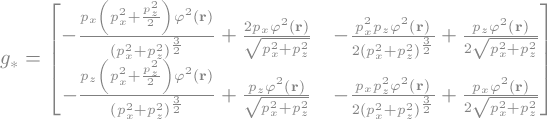

In [136]:
gmeq.gstar_varphi_pxpz_eqn

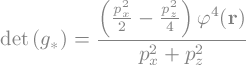

In [137]:
gmeq.det_gstar_varphi_pxpz_eqn

In [138]:
sub1 = {px:0.01,pz:-1,varphi_r(rvec):1, varphi_0:1,x_1:1,rx:0, varepsilon:0}
sub2 = {px:1,pz:-1,varphi_r(rvec):1, varphi_0:1,x_1:1,rx:0, varepsilon:0}

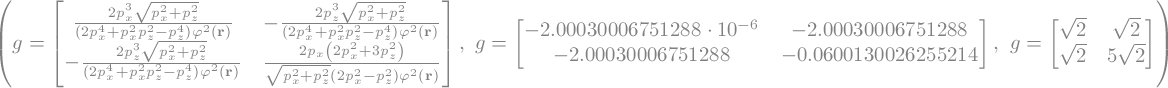

In [139]:
gmeq.g_varphi_pxpz_eqn, gmeq.g_varphi_pxpz_eqn.subs(sub1), gmeq.g_varphi_pxpz_eqn.subs(sub2)

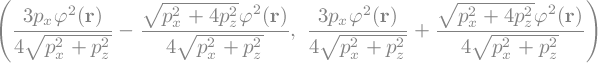

In [140]:
gmeq.gstar_eigen_varphi_pxpz[0][0], gmeq.gstar_eigen_varphi_pxpz[1][0] 

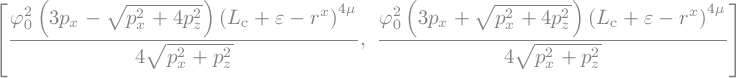

In [141]:
[ev for ev in gmeq.gstar_eigenvalues]

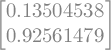

In [142]:
rnd = lambda x: round(x,8)
(gmeq.gstar_eigenvalues.subs(sub1)).applyfunc(rnd), 
(gmeq.gstar_eigenvalues.subs(sub2)).applyfunc(rnd)

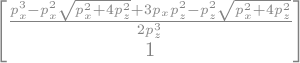

In [143]:
gmeq.gstar_eigenvectors[0] if gmeq.gstar_eigenvectors is not None else None

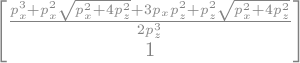

In [144]:
gmeq.gstar_eigenvectors[1] if gmeq.gstar_eigenvectors is not None else None

# Indicatrix & figuratrix

In [145]:
gmeq.define_idtx_fgtx_eqns()

Closed-form solutions for the indicatrix & figuratrix can be found if the following is solvable in $\cos^2\beta$:

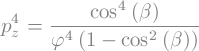

In [146]:
gmeq.pz_cosbeta_varphi_eqn if gmeq.pz_cosbeta_varphi_eqn is not None else None

In [147]:
expand( Eq( gmeq.pz_cosbeta_varphi_eqn.lhs*denom(gmeq.pz_cosbeta_varphi_eqn.rhs)
               -numer(gmeq.pz_cosbeta_varphi_eqn.rhs),0 ) )

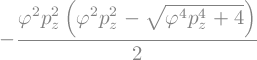

In [148]:
factor( gmeq.cosbetasqrd_pz_varphi_solns[0] ) \
    if gmeq.cosbetasqrd_pz_varphi_solns is not None else None

In [149]:
# cosbetasqrd_pz_varphi_solns = solve( gmeq.pz_cosbeta_varphi_eqn, cos(beta)**2 )
# cosbetasqrd_pz_varphi_solns

In [150]:
# N( cosbetasqrd_pz_varphi_solns[0].subs({varphi:10,pz:-0.1}) )

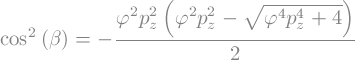

In [151]:
factor( gmeq.fgtx_cossqrdbeta_pz_varphi_eqn ) \
    if gmeq.fgtx_cossqrdbeta_pz_varphi_eqn is not None else None

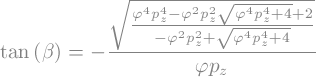

In [152]:
factor( gmeq.fgtx_tanbeta_pz_varphi_eqn  )\
    if gmeq.fgtx_tanbeta_pz_varphi_eqn is not None else None

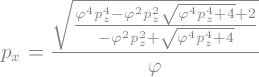

In [153]:
gmeq.fgtx_px_pz_varphi_eqn if gmeq.fgtx_px_pz_varphi_eqn is not None else None

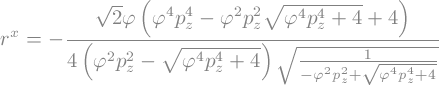

In [154]:
factor( gmeq.idtx_rdotx_pz_varphi_eqn ) if gmeq.idtx_rdotx_pz_varphi_eqn is not None \
                              else None

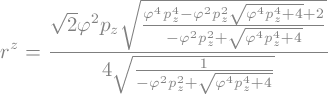

In [155]:
gmeq.idtx_rdotz_pz_varphi_eqn if gmeq.idtx_rdotz_pz_varphi_eqn is not None \
                              else None

# Geodesic equations

### Preamble

In [156]:
gmeq.prep_geodesic_eqns(parameters=sub)

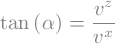

In [157]:
gmeq.tanalpha_rdot_eqn

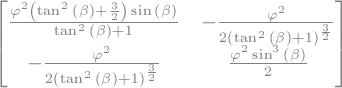

In [158]:
gmeq.gstar_ij_tanbeta_mat if gmeq.gstar_ij_tanbeta_mat is not None else None

In [159]:
gmeq.tanbeta_poly_eqn

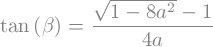

In [160]:
gmeq.tanbeta_eqn

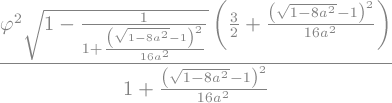

In [161]:
gmeq.gstar_ij_tanalpha_mat[0] if gmeq.gstar_ij_tanalpha_mat is not None else None

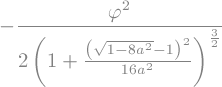

In [162]:
gmeq.gstar_ij_tanalpha_mat[1] if gmeq.gstar_ij_tanalpha_mat is not None else None

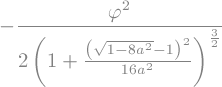

In [163]:
gmeq.gstar_ij_tanalpha_mat[2] if gmeq.gstar_ij_tanalpha_mat is not None else None

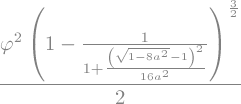

In [164]:
gmeq.gstar_ij_tanalpha_mat[3] if gmeq.gstar_ij_tanalpha_mat is not None else None

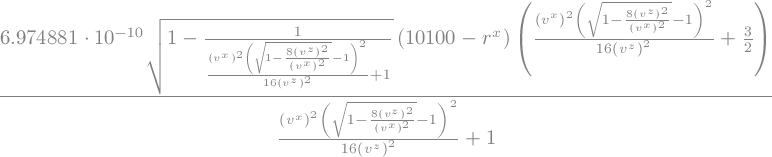

In [165]:
gmeq.gstar_ij_mat[0] if gmeq.gstar_ij_mat is not None else None

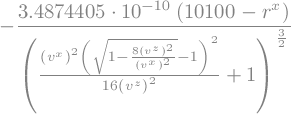

In [166]:
gmeq.gstar_ij_mat[1] if gmeq.gstar_ij_mat is not None else None

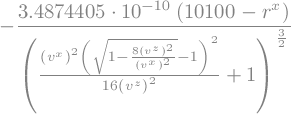

In [167]:
gmeq.gstar_ij_mat[2] if gmeq.gstar_ij_mat is not None else None

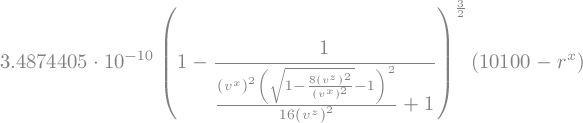

In [168]:
gmeq.gstar_ij_mat[3] if gmeq.gstar_ij_mat is not None else None

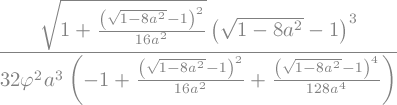

In [169]:
gmeq.g_ij_tanalpha_mat[0] if gmeq.g_ij_tanalpha_mat is not None else None

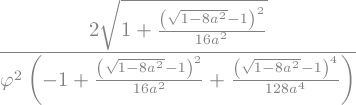

In [170]:
gmeq.g_ij_tanalpha_mat[1] if gmeq.g_ij_tanalpha_mat is not None else None

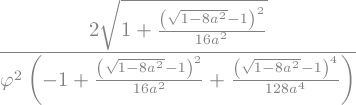

In [171]:
gmeq.g_ij_tanalpha_mat[2] if gmeq.g_ij_tanalpha_mat is not None else None

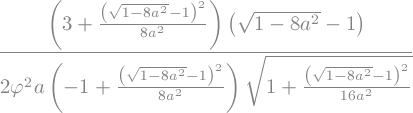

In [172]:
gmeq.g_ij_tanalpha_mat[3] if gmeq.g_ij_tanalpha_mat is not None else None

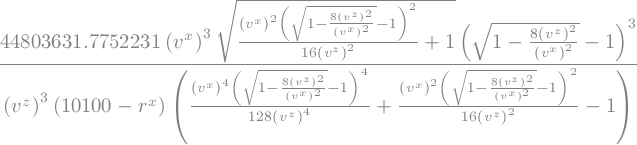

In [173]:
gmeq.g_ij_mat[0] if gmeq.g_ij_mat is not None else None

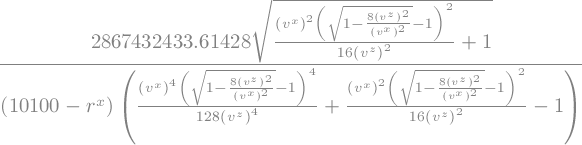

In [174]:
gmeq.g_ij_mat[1] if gmeq.g_ij_mat is not None else None

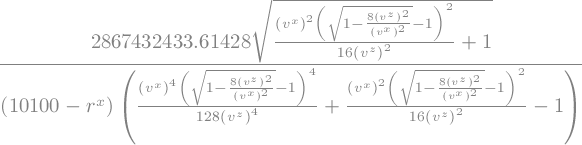

In [175]:
gmeq.g_ij_mat[2] if gmeq.g_ij_mat is not None else None

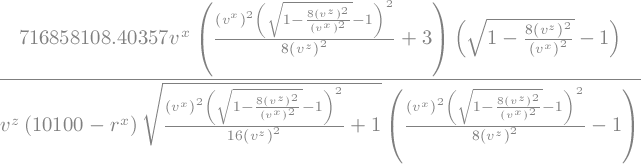

In [176]:
gmeq.g_ij_mat[3] if gmeq.g_ij_mat is not None else None

### Main

In [177]:
gmeq.define_geodesic_eqns(parameters=sub)

In [178]:
gmeq.geodesic_eqns[0:2] if gmeq.geodesic_eqns is not None else None

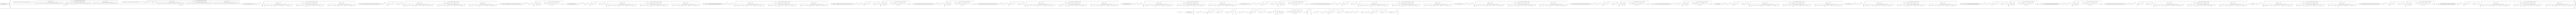

limit_output extension: Maximum message size of 40000 exceeded with 77107 characters

In [179]:
factor(gmeq.geodesic_eqns[2]) if gmeq.geodesic_eqns is not None else None

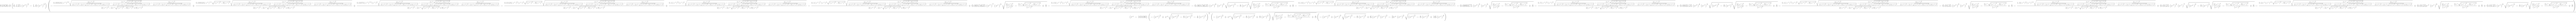

limit_output extension: Maximum message size of 40000 exceeded with 59516 characters

In [180]:
factor(gmeq.geodesic_eqns[3]) if gmeq.geodesic_eqns is not None else None

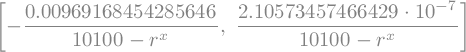

In [181]:
([eqn_.subs({rdotx:0.1,rdotz:0.01*sign(gmeq.eta)}) for eqn_ in gmeq.geodesic_eqns[2:4]] \
    if gmeq.geodesic_eqns is not None else None)

# Initial conditions

In [182]:
gmeq.prep_ibc_eqns()

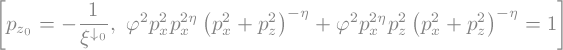

In [183]:
eqns(['pz0_xiv0_eqn','pzpx_unity_eqn'])

In [184]:
gmeq.define_ibc_eqns()

In [185]:
[[key for key in gmeq.boundary_eqns[bc_type].keys()]
   for bc_type in gmeq.boundary_eqns.keys()]

[['h', 'gradh'], ['h', 'gradh'], ['h', 'gradh']]

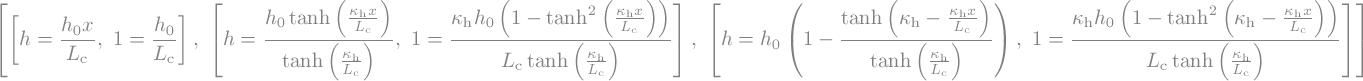

In [186]:
[[value for value in gmeq.boundary_eqns[bc_type].values()]
  for bc_type in gmeq.boundary_eqns.keys()]

In [187]:
gmeq.set_ibc_eqns()

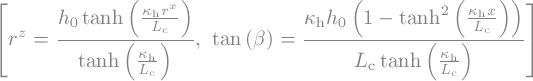

In [188]:
eqns(['rz_initial_eqn','tanbeta_initial_eqn'])

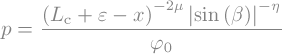

In [189]:
gmeq.p_initial_eqn

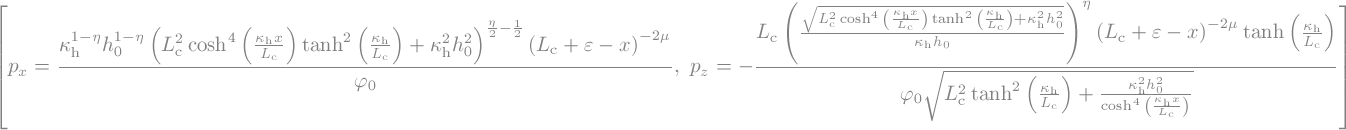

In [190]:
eqns(['px_initial_eqn','pz_initial_eqn'])

# Misc

In [191]:
x = symbols('x',  real=True)
y = symbols('y',  real=True)
b = symbols('b',  real=True)

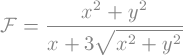

In [192]:
F_eqn = Eq(F, (x**2+y**2)/(3*sqrt(x**2+y**2)+x)   )
F_eqn

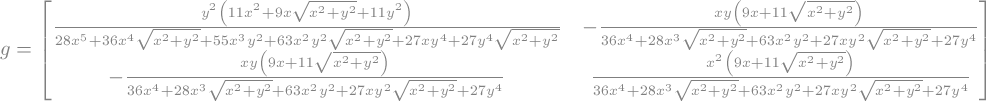

In [193]:
g_eqn = Eq(g, simplify(
    Matrix([[ diff(F_eqn.rhs,x,x), diff(F_eqn.rhs,x,y) ],
            [ diff(F_eqn.rhs,y,x), diff(F_eqn.rhs,y,y) ]]) ))
g_eqn

In [194]:
simplify( g_eqn.rhs[0]*g_eqn.rhs[3] - g_eqn.rhs[1]*g_eqn.rhs[2] )

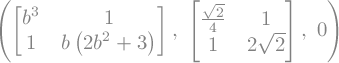

In [195]:
b_mat = simplify(
    Matrix([[ b**3, 1 ],
            [ 1, 2*b**3+3*b ]]) )
b_mat, b_mat.subs({b:sqrt(2)/2}), b_mat.det().subs({b:sqrt(2)/2})

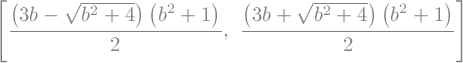

In [196]:
b_mat_eigenvals = [simplify(ev_[0]) for ev_ in (b_mat.eigenvects())]
b_mat_eigenvals

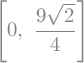

In [197]:
[ev_.subs({b:sqrt(2)/2}) for ev_ in b_mat_eigenvals]

# Anisotropy

In [198]:
gmeq.define_psi_eqns()

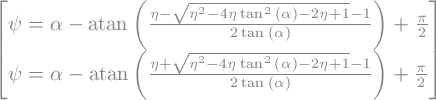

In [199]:
gmeq.tanbeta_alpha_eqns
psi_alpha_eta_eqns = [
    gmeq.psi_alpha_beta_eqn.subs({beta:atan(tanbeta_alpha_eqn_.rhs)})
    for tanbeta_alpha_eqn_ in gmeq.tanbeta_alpha_eqns]
Matrix(psi_alpha_eta_eqns)

In [200]:
psi_eta_beta_lambdas = [lambdify( (eta, alpha),psi_alpha_eta_eqn_.rhs )
                        for psi_alpha_eta_eqn_ in psi_alpha_eta_eqns]
psi_eta_beta_lambdas

[<function _lambdifygenerated(Dummy_1340, Dummy_1341)>,
 <function _lambdifygenerated(Dummy_1342, Dummy_1343)>]

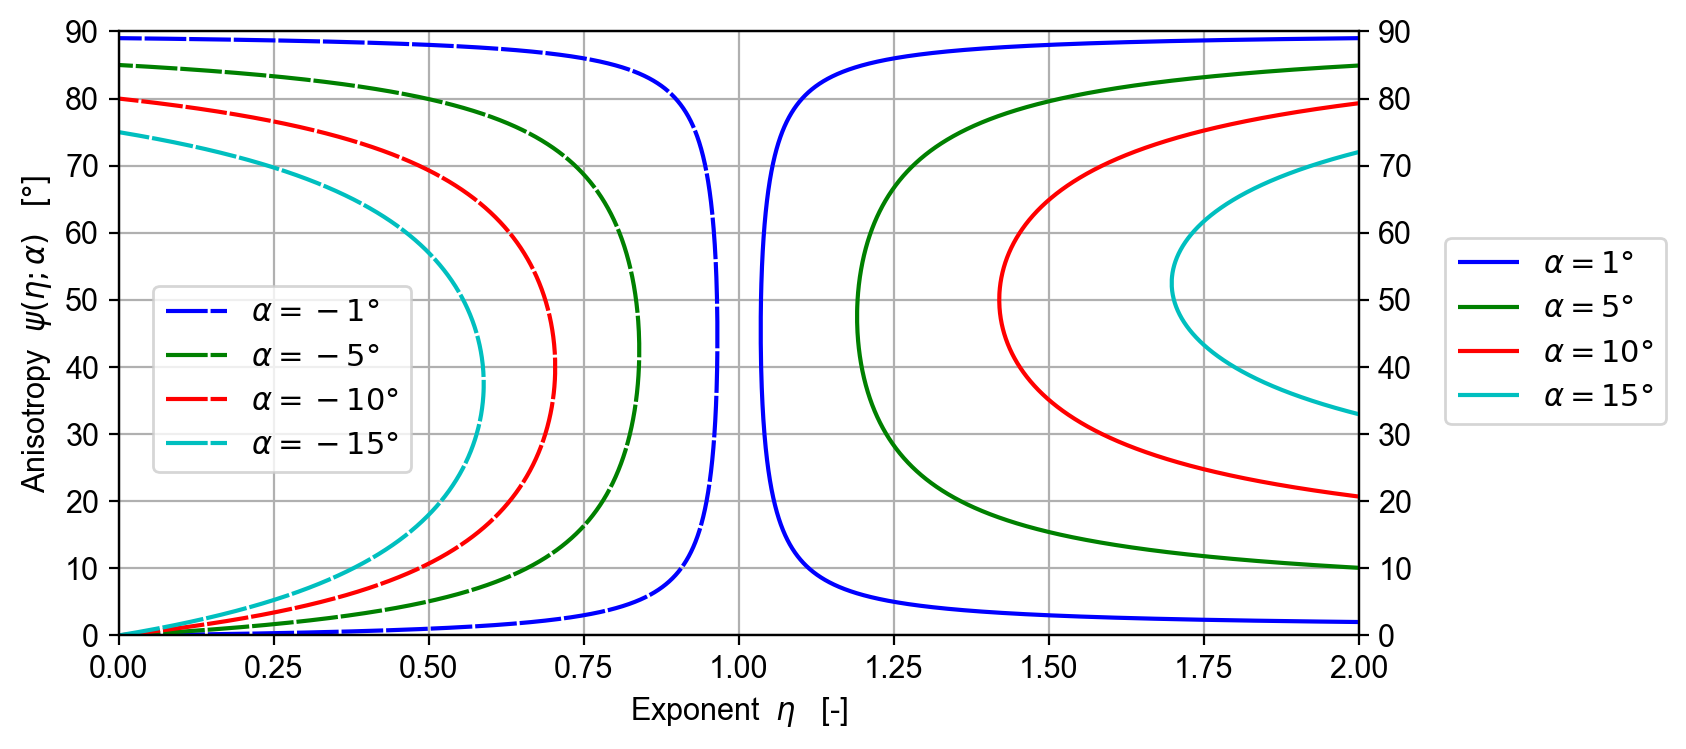

In [201]:
from cycler import cycler

fig = gr.create_figure('psi_eta_alpha', fig_size=(8,4))
axes = plt.gca()
default_cycler = cycler(color='bgrcmyk')

plt.grid(':')
plt.ylabel(r'Anisotropy  $\psi(\eta; \alpha)$   [$\degree$]')
plt.xlabel(r'Exponent  $\eta$   [-]')
plt.xlim(0,2)
rd = np.deg2rad
y_limits=[0,90]

def plot_partial(eta_range_, axes_, dashes_, alpha_sign_, y_limits_, loc_):
    eta_array_ = np.linspace(*eta_range_,5000)
    axes_.set_prop_cycle(default_cycler)
    for alpha_ in [1,5,10,15]:
        psi_array_ = np.concatenate([
            [psi_eta_beta_lambdas[0](eta_, rd(alpha_*alpha_sign_)) 
             for eta_ in (eta_array_ if alpha_sign_==-1 else np.flip(eta_array_))],
            [psi_eta_beta_lambdas[1](eta_, rd(alpha_*alpha_sign_)) 
             for eta_ in (np.flip(eta_array_) if alpha_sign_==-1 else eta_array_)]
        ])
        eta_rept_array_ = np.concatenate(
            [eta_array_, np.flip(eta_array_)] 
            if alpha_sign_==-1 else [np.flip(eta_array_),eta_array_] )
        eta_rept_array_ = eta_rept_array_[np.isfinite(psi_array_)]
        psi_array_ = psi_array_[np.isfinite(psi_array_)]
        axes_.plot(eta_rept_array_, np.rad2deg(psi_array_), dashes=dashes_,
                 label=rf'$\alpha={alpha_*alpha_sign_}\degree$')
    axes_.set_ylim(*y_limits_)
    axes_.legend(loc=loc_);

plot_partial([0,1],  axes, [10,0.7], -1, y_limits, [0.028,0.27])
plot_partial([1,2], axes.twinx(), [1,0], +1, y_limits, [1.07,0.35])